- Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

- Stats for time series Data

In [2]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller

- Quality metrics

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

- DateTime and warning

In [4]:
import warnings
warnings.filterwarnings("ignore")
from DateTime import DateTime

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## EDA
- Analisis exploratorio para poder ver la distribucion de los datos y determinar sus propiedades

- Selection of Data

In [3]:
df= pd.read_csv('../Data/apple.csv',sep=',',encoding='utf-8')

In [4]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/29/2024,$190.29,53068020,$189.61,$192.247,$189.51
1,05/28/2024,$189.99,52280050,$191.51,$193.00,$189.10
2,05/24/2024,$189.98,36326980,$188.82,$190.58,$188.0404
3,05/23/2024,$186.88,51005920,$190.98,$191.00,$186.625
4,05/22/2024,$190.90,34648550,$192.265,$192.8231,$190.27


- Only working with closing values

In [3]:
df= df[['Date','Close/Last']]
df['Close/Last']=df['Close/Last'].str.replace('$','',regex=False).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2517 non-null   object 
 1   Close/Last  2517 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


- Passing Date to datetime

In [4]:
df['Date']= pd.to_datetime(df['Date'])

- Organizing the Data

In [5]:
df.sort_values(by='Date',inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)

- Plotting the Data

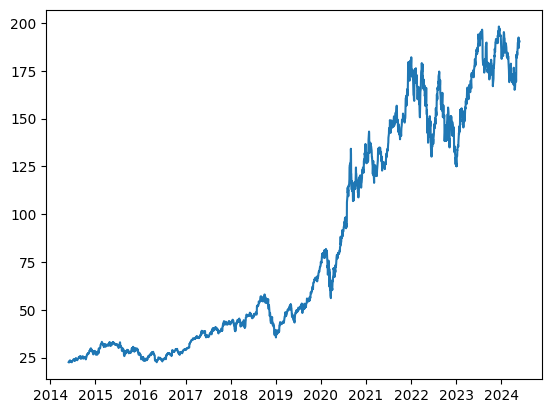

In [6]:
plt.plot(df['Date'], df['Close/Last'])

- Setting the Data datetimeindex

In [7]:
df.set_index('Date',inplace=True)

- In order to work with this Algorithm and apply many different transformations trough the datetimeindex, is necessary to set the frequency of the data to 'Daily, if the data is not inferedl those manipulations and transformations are going to be more difficult to set

- Function to create shifts or time-steps

In [8]:
def transform_df(df,n_steps):
    
    for i in range(1,n_steps+1):
        df[f'Close (t-{i})']= df['Close/Last'].shift(i)
        
    df.dropna(inplace=True)
    return df
     

- Transformation of the data

In [9]:
data= transform_df(df,6)
data.head()

,Close/Last,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6)
Date,,,,,,,
2014-06-09,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518,22.6072
2014-06-10,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518
2014-06-11,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693
2014-06-12,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293
2014-06-13,22.8200,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197


In [10]:
df=df.asfreq('D')
df.ffill(inplace=True)
freq= pd.infer_freq(df.index)
print(freq)

D


- Head para corroborar cambios efectuados

In [13]:
df.head(2)

,Close/Last,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6)
Date,,,,,,,
2014-06-09,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518,22.6072
2014-06-10,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518
2014-06-11,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693
2014-06-12,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293
2014-06-13,22.8200,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197


- Transforma todos los datos del dataset a arrays

In [11]:
data_array= df.to_numpy()
data_array

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [22]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)
transformed

array([[-0.99025863, -0.99446166, -0.99373704, ..., -0.99772929,
        -1.        , -0.99823065],
       [-0.98869204, -0.99025863, -0.99446166, ..., -0.994767  ,
        -0.99638503, -1.        ],
       [-0.98980289, -0.98869204, -0.99025863, ..., -0.99373704,
        -0.99342473, -0.99638503],
       ...,
       [ 0.90737154,  0.87205195,  0.91785348, ...,  0.91944856,
         0.90618144,  0.90583986],
       [ 0.90748547,  0.90737154,  0.87205195, ...,  0.93437393,
         0.91950276,  0.90618144],
       [ 0.9109035 ,  0.90748547,  0.90737154, ...,  0.91785348,
         0.93441809,  0.91950276]])